In [1]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])

First, remove artefacts, center and smoothen the raw GROMACS trajectories using the `trjconv` module.

```bash
gmx trjconv -s md500.tpr -f md500.xtc -n index.ndx -o md500_compact.xtc -center -pbc mol -ur compact
gmx trjconv -s md500.tpr -f md500_compact.xtc -n index.ndx -o md500_compact_compact.xtc -fit rot+trans
```

Dump out the first frame of the trajectory

```bash
gmx trjconv -s md500.tpr -f md500_compact.xtc -n index.ndx -o md500_start.pdb -dump 0
```

In all cases, Choose `Protein` for centering and `Protein_LIG_ZN2` for output. Not selecting the whole system for output removes water and loose ions and compresses the trajectory files.



## RMSD Calculation

In [2]:
from MDAnalysis.analysis import rms
#Read all the trajectories
mmp9_sb3ct = mda.Universe('/home/daneel/1l6j-run1/md500_start.pdb', '/home/daneel/1l6j-run1/md500_compact_compact.xtc')

In [3]:
R = rms.RMSD(mmp9_sb3ct,  # universe to align
    mmp9_sb3ct,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

R.run(verbose=True)
times_p = R.results.rmsd[:,1]
rmsd_p = R.results.rmsd[:,2]

  0%|          | 0/50001 [00:00<?, ?it/s]

## Radius of Gyration Calculation

In [6]:
from tqdm import tqdm
group = mmp9_sb3ct.select_atoms('protein')		# change the atom selection for your specific system

Frame = []
times = []
Rgyr = []
for ts in tqdm(mmp9_sb3ct.trajectory):
	Frame.append(ts.frame)
	times.append(mmp9_sb3ct.trajectory.time)
	Rgyr.append(group.radius_of_gyration())

Rgyrc_table = np.vstack((Frame, times, Rgyr)).T

100%|██████████| 50001/50001 [00:55<00:00, 908.71it/s] 


## RMSF Calculation

Between protein backbone and Carbon alphas.

In [8]:
c_alphas_c = mmp9_sb3ct.select_atoms('backbone and name CA')
R_c = rms.RMSF(c_alphas_c).run(verbose=True)

  0%|          | 0/50001 [00:00<?, ?it/s]

In [14]:
mda.__version__

'2.8.0'

## H-bond analysis:

**Note:** As of today (20241222), the latest version of MDAnalysis (2.8) cannot read binary topology files (the ones with the `.tpr` extension) created by gromacs version 2024.4. Binary topology data is necessary for hydrogen bond analysis, so I am trying `MDTraj` instead.


In `MDTraj`, the Baker-Hubbard Hydrogen Bond Identification can be used, where the hydrogen bond is said to have formed if:

1. The angle $\theta_{dha}>2\pi/3$, *i.e.*, $120$ degrees, and
2. The distance $r_{ha}<0.25\;nm$. 
   
Here, $d$ means 'donor', 'h' means 'hydrogen', and 'a' means acceptor.
The donors considered by this method are NH and OH, and the acceptors considered are O and N.

In [19]:
%%time
import numpy as np
import mdtraj as md

xtcfile='/home/daneel/1l6j-run1/md500_compact_compact.xtc'
topfile='/home/daneel/1l6j-run1/md500_start.pdb'

CPU times: user 298 ms, sys: 536 ms, total: 834 ms
Wall time: 15.3 s


Do not load the whole trajectory, as it will take up too much memory. Unlike `MDAnalysis`, `MDTraj` doesn't do lazy loads from disk, but fully operates in memory. This makes it faster, but memory-intensive.

So, we choose a 'stride' of, say, $60$ frames, and have `MDTraj` load every $60^{th}$ frame of the trajectory, then run the baker-hubbard algorithm.

In [76]:
stride = 60
total_frames = 50000
total_time_ns = 500

timestep  = (stride/total_frames) * total_time_ns

full_traj = md.load_xtc(xtcfile, stride=stride, top=topfile)
sb3ct_atoms = full_traj.topology.select('resname LIG')
hbonds = md.baker_hubbard(full_traj, periodic=False, freq=0.01)
label = lambda hbond : '%s - %s ... %s' % ( full_traj.topology.atom(hbond[0]),\
                                            full_traj.topology.atom(hbond[1]),\
                                            full_traj.topology.atom(hbond[2]))
sb3ct_hbonds = []
for hbond in hbonds:
    d,h,a = hbond
    if d in sb3ct_atoms or a in sb3ct_atoms:
        sb3ct_hbonds.append(hbond)
        print(label(hbond))

sb3ct_hbonds = np.array(sb3ct_hbonds)

ARG424-N - ARG424-H ... LIG502-O
ARG424-N - ARG424-H ... LIG502-O1


So, according to `MDTraj` Baker-Hubbard hbond detector, there are only $2$ hydrogen bonds that form at more than a frequency of `freq=` $0.01$ in the trajectory frames.

Calculate the distances and angles for each hbond.

In [77]:
da_distances = md.compute_distances(full_traj, sb3ct_hbonds[:, [1,2]], periodic=False)
da_angles = md.compute_angles(full_traj, sb3ct_hbonds, periodic=False)

Let us get the number of hbonds between protein and ligand.

In [89]:
distance_met = da_distances < 0.25
angle_met = da_angles > 2 * np.pi/3
hbond_met = np.logical_and(distance_met, angle_met)
num_hbonds = np.sum(hbond_met, axis=1)

## Plots

In [90]:
npanels = 3
fig, axs = plt.subplots(npanels,1, sharex=True, tight_layout=True)

ax_rmsd = axs[0]
ax_rmsd.set_ylabel(r'RMSD (nm)');

ax_rmsd.plot(times_p/1000, rmsd_p/10, label="MMP9-SB3CT", 
        color='orange')

ax_rmsd.legend()

ax_rg = axs[1]
ax_rg.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10, 
        label="MMP9-SB3CT", color='orange')
ax_rg.set_ylabel(r'$R_g$ (nm)');

ax_bonds = axs[2]
ax_bonds.set_xlabel(r'time (ns)');

ax_bonds.plot(timestep * np.arange(nframes), num_hbonds, lw=1, label="MMP9-SB3CT", alpha=0.5,color='blue')

ax_bonds.set_ylabel(r"$N_{HB}$")
#plt.savefig("time-series-plots.png", dpi=600)
plt.show()

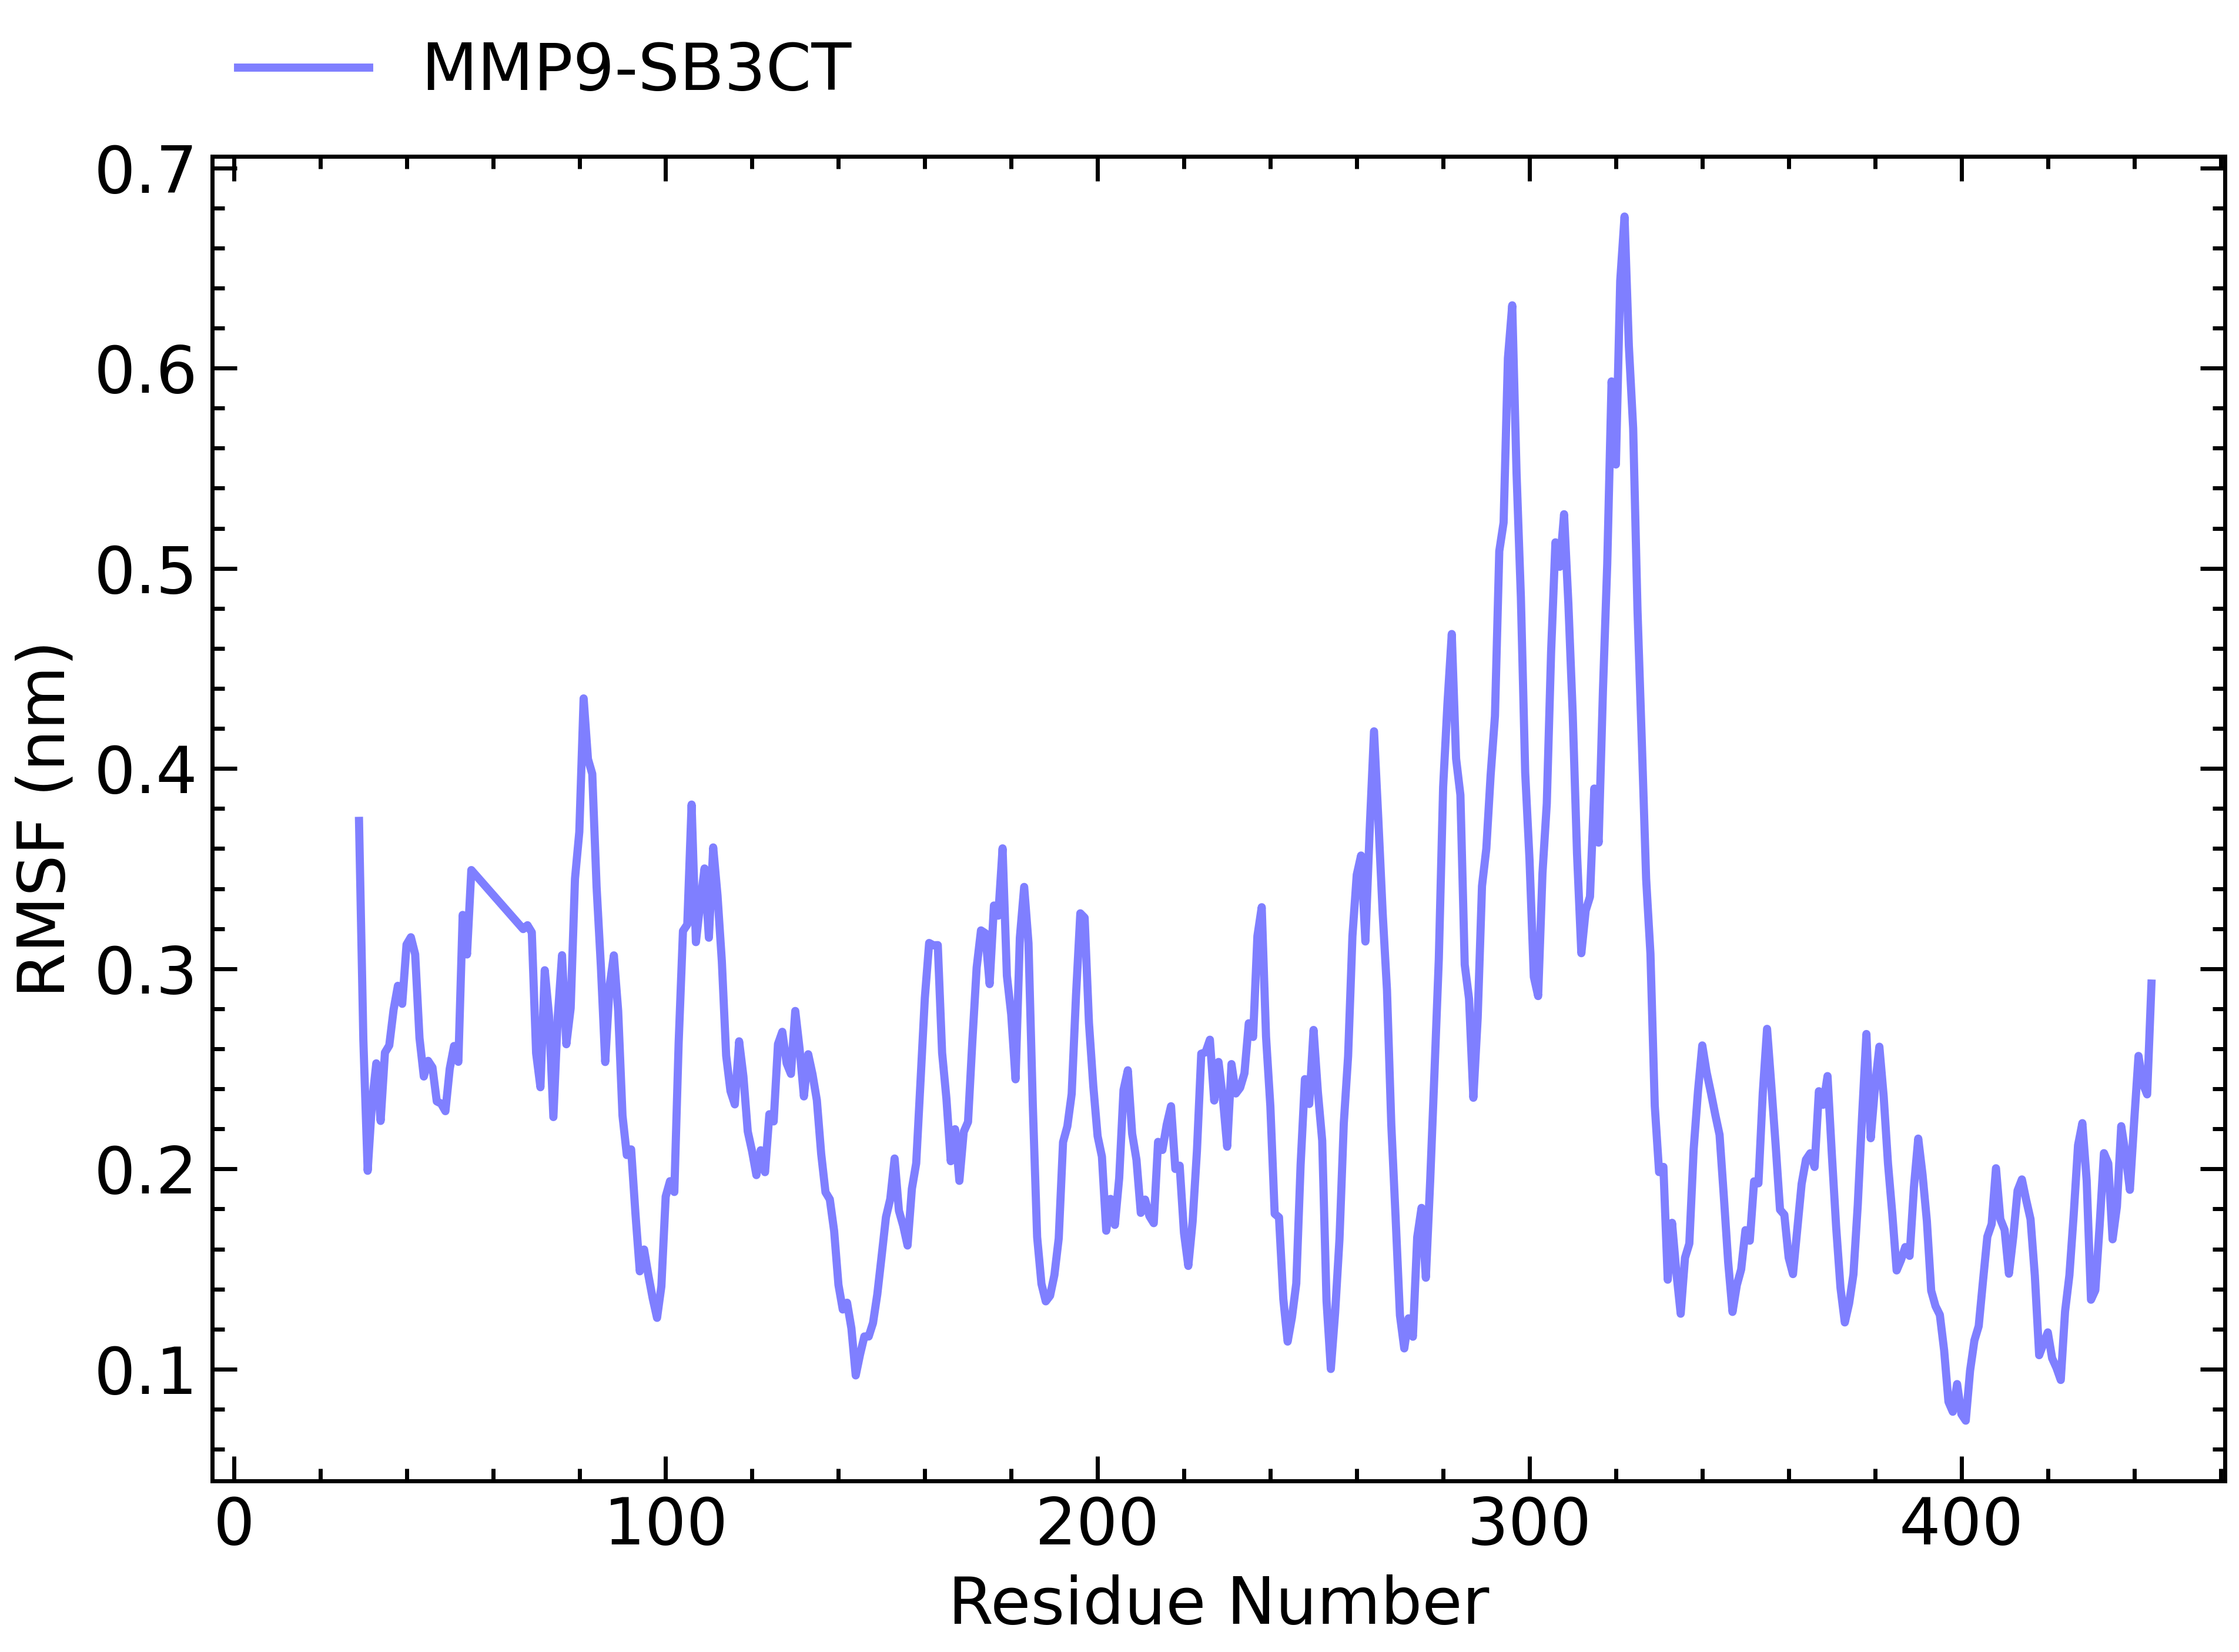

In [91]:
import matplotlib.pyplot as plt

line_c, = plt.plot(c_alphas_c.resids, R_c.results.rmsf/10, label="MMP9-SB3CT", 
                alpha=0.5, color="blue")

plt.xlabel('Residue Number')
plt.ylabel('RMSF (nm)')
plt.xlim(-5, 461)
#ax1.set_ylim(-0.02, 0.45)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
            ncols=2, mode="expand", borderaxespad=0.);

In [98]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
fig.suptitle('MMP9-SB3CT: Hbond kinetics with N (ARG-424) donor')
nframes, n_hbonds = da_distances.shape
ax0.plot(timestep * np.arange(nframes), da_distances[:,0], label=r'$N-H\cdots O$')
ax0.plot(timestep * np.arange(nframes), da_distances[:,1], label=r'$N-H\cdots O_1$')
ax0.axhline(0.25, color='black', linestyle='--')
ax0.set_ylabel(r'$r_{ha}$ (nm)')


nframes, n_hbonds = da_angles.shape
ax1.plot(timestep * np.arange(nframes), da_angles[:,0],label=r'$N-H\cdots O$')
ax1.plot(timestep * np.arange(nframes), da_angles[:,1],label=r'$N-H\cdots O_1$')
ax1.axhline(2 * np.pi/3, color='black', linestyle='--')
ax1.set_ylabel(r'$\theta_{dha}$')

ax1.set_xlabel('Time (ns)')
ax1.legend();


As can be seen from the above analysis, there is basically just one hbond being consistently detected, namely, $N (424-ARG)-H\cdots O_1$ that shifts acceptors from $O$ to $O_1$ midway during the dynamics.

## Principal Component Analysis

Following the PCA HOWTO in the [MDAnalysis userguide](https://userguide.mdanalysis.org/stable/examples/analysis/reduced_dimensions/pca.html)

In [3]:
from MDAnalysis.analysis import pca, align
import nglview as nv

import warnings
# suppress some MDAnalysis warnings about writing PDB files
warnings.filterwarnings('ignore')

/usr/local/miniforge3/envs/gromacs/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [4]:
aligner = align.AlignTraj(mmp9_sb3ct, mmp9_sb3ct, select='backbone', in_memory=False).run(verbose=True)

  0%|          | 0/50001 [00:00<?, ?it/s]

In [5]:
pc = pca.PCA(mmp9_sb3ct, select='backbone', align=True, mean=None, n_components=10).run(verbose=True)

  0%|          | 0/50001 [00:00<?, ?it/s]

There are 1619 backbone atoms in the analysis
(4857, 10)


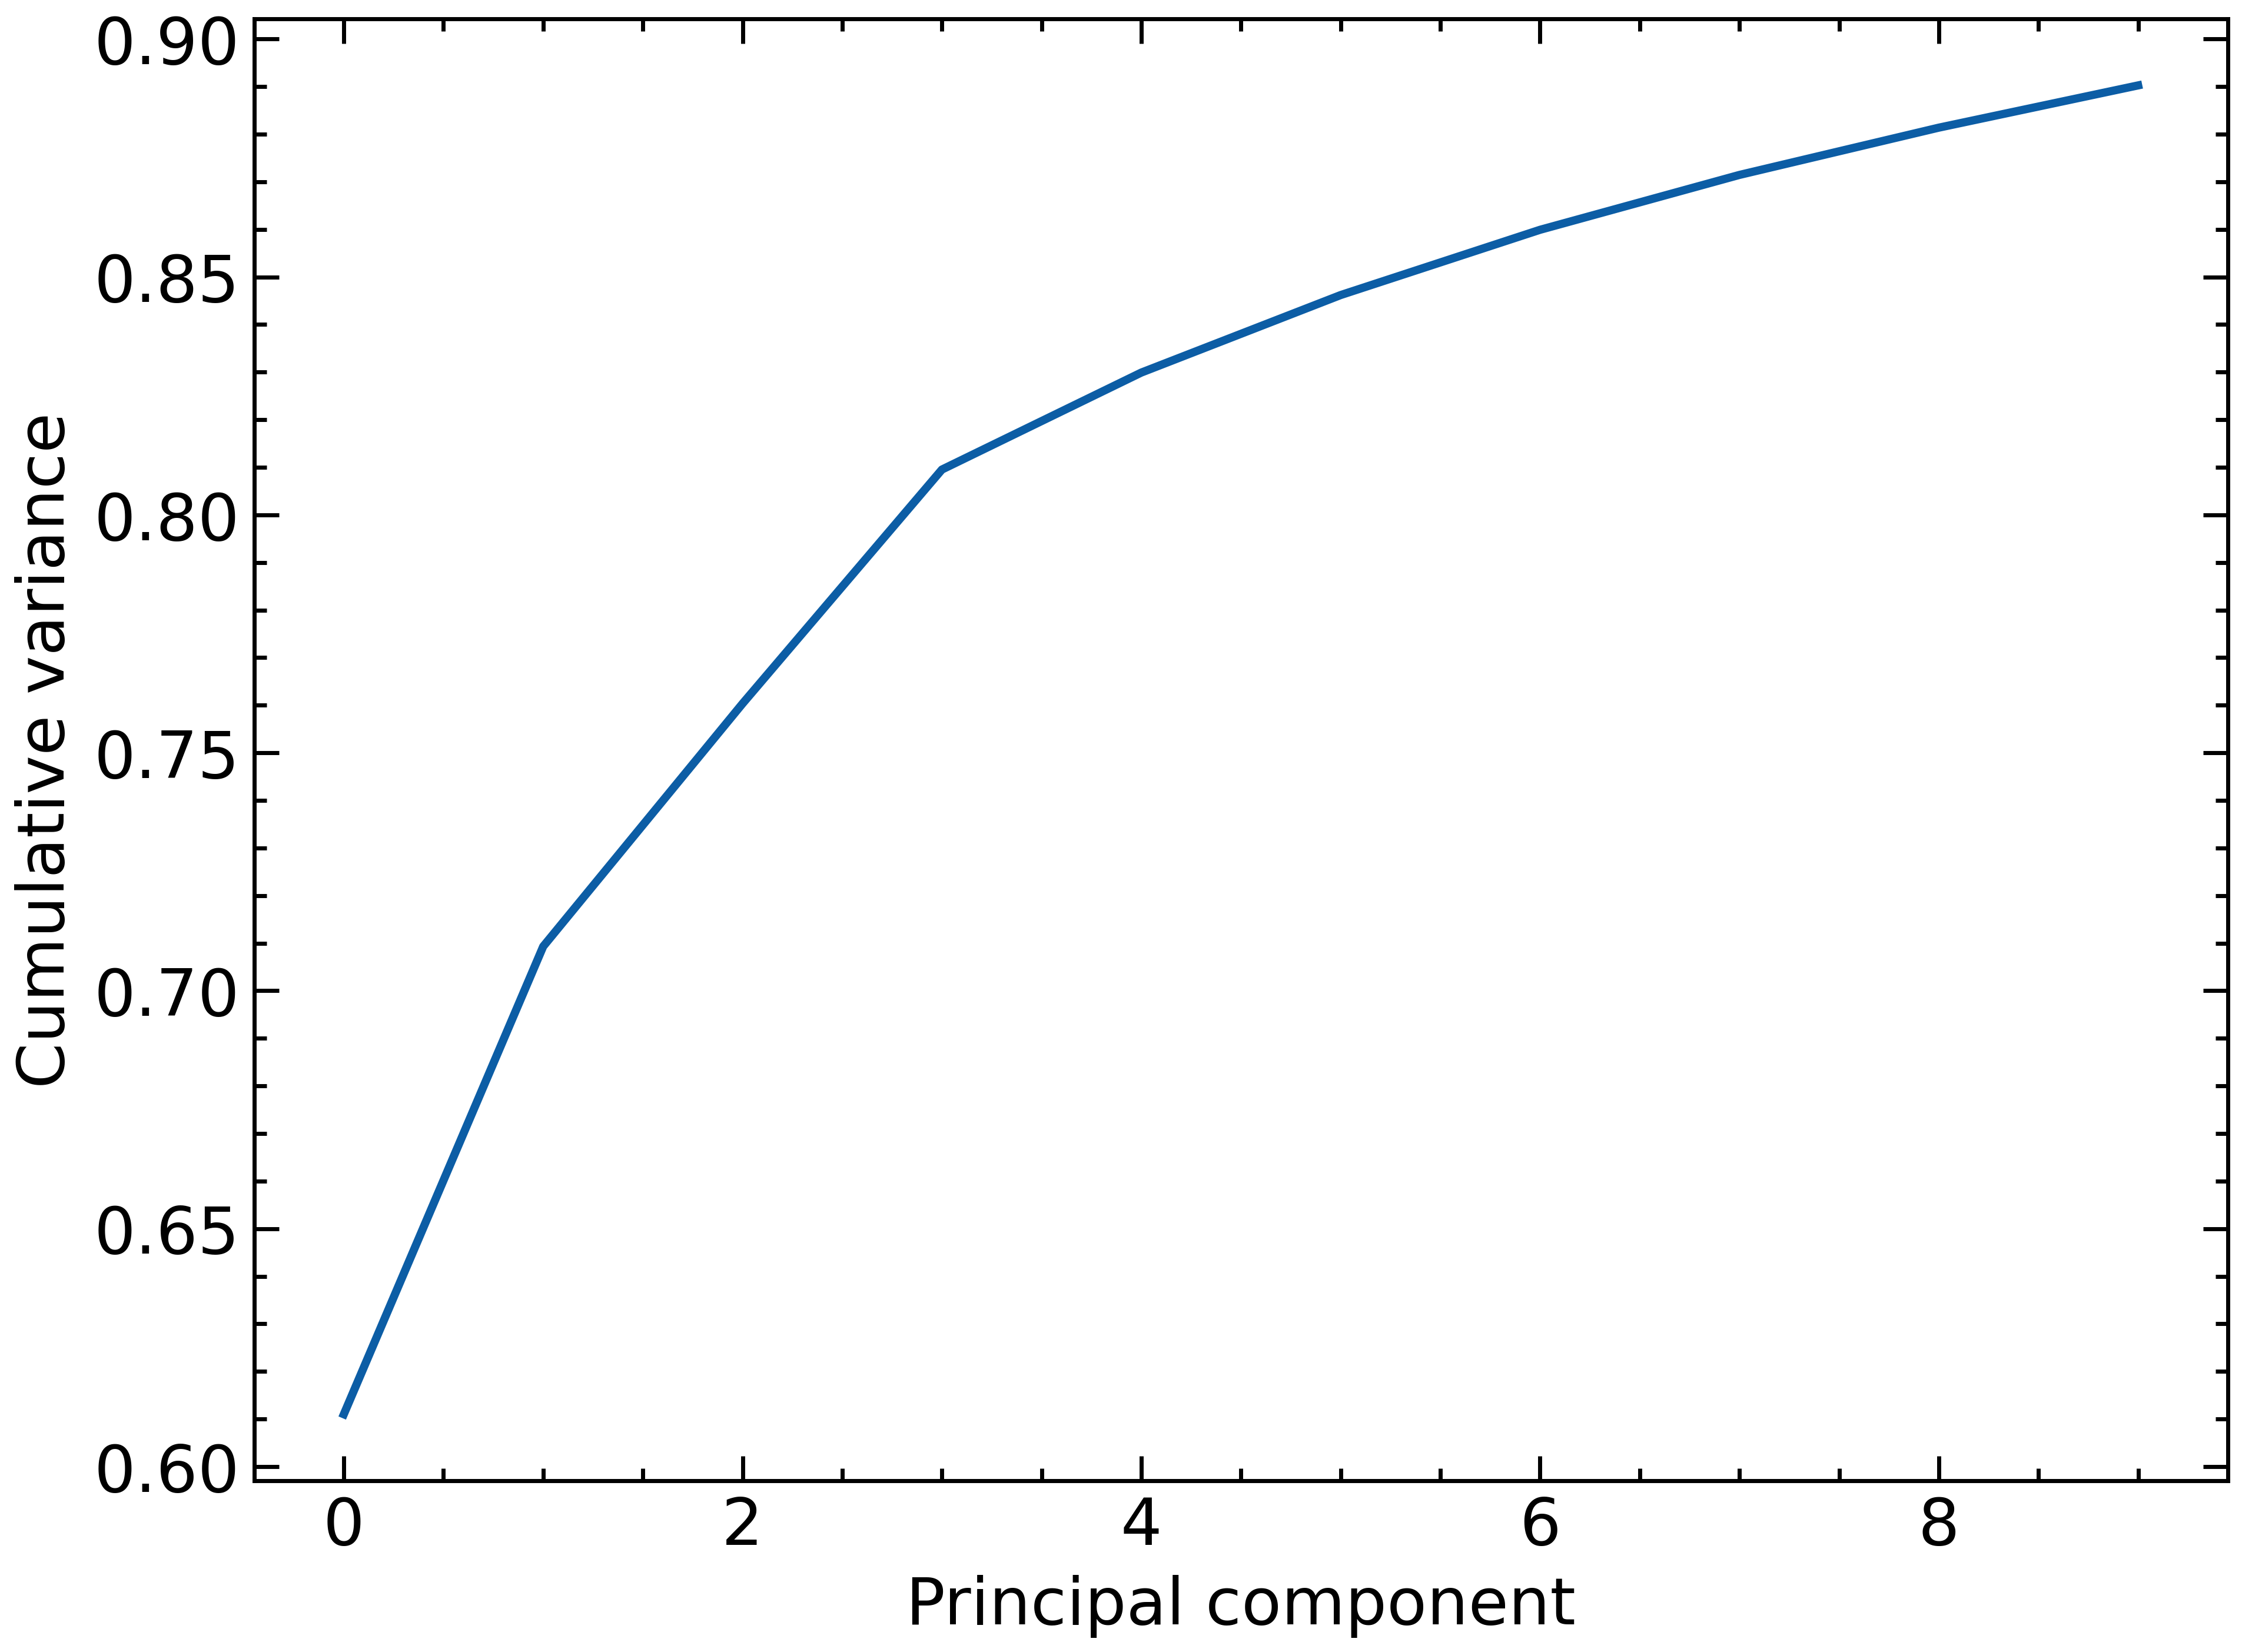

In [6]:
backbone = mmp9_sb3ct.select_atoms('backbone')
n_bb = len(backbone)
print('There are {} backbone atoms in the analysis'.format(n_bb))
print(pc.p_components.shape)
plt.plot(pc.cumulated_variance[:10])
plt.xlabel('Principal component')
plt.ylabel('Cumulative variance')
plt.show()

**Notabene:** The cumulative variances are kinda cruddy here. You need to go to more than $10$ dimensions to get around $90\%$ of the correlations. However, that's too many dimensions, and we'll have to stick to $2$, as unrepresentative as this will be.

In [8]:
import pandas as pd
pca_components = 2
transformed = pc.transform(backbone, n_components=pca_components)
df = pd.DataFrame(transformed, columns=['PC{}'.format(i+1) for i in range(pca_components)])
df['Time (ps)'] = df.index * mmp9_sb3ct.trajectory.dt
df.head()


PC1        PC2  Time (ps)
0 -12.689005 -63.039588        0.0
1 -27.589223 -55.039610       10.0
2 -39.886734 -57.437947       20.0
3 -37.461572 -62.395702       30.0
4 -30.916914 -61.047206       40.0

This $PC1$ vs $PC2$ data is now seen in the $xy$ plane. The data is binned into a $2D$ histogram and filtered by a Gaussian for smoothening, yielding the dimensionless density of points $\rho$. The histogram is normalized so that the maximum value is unity.

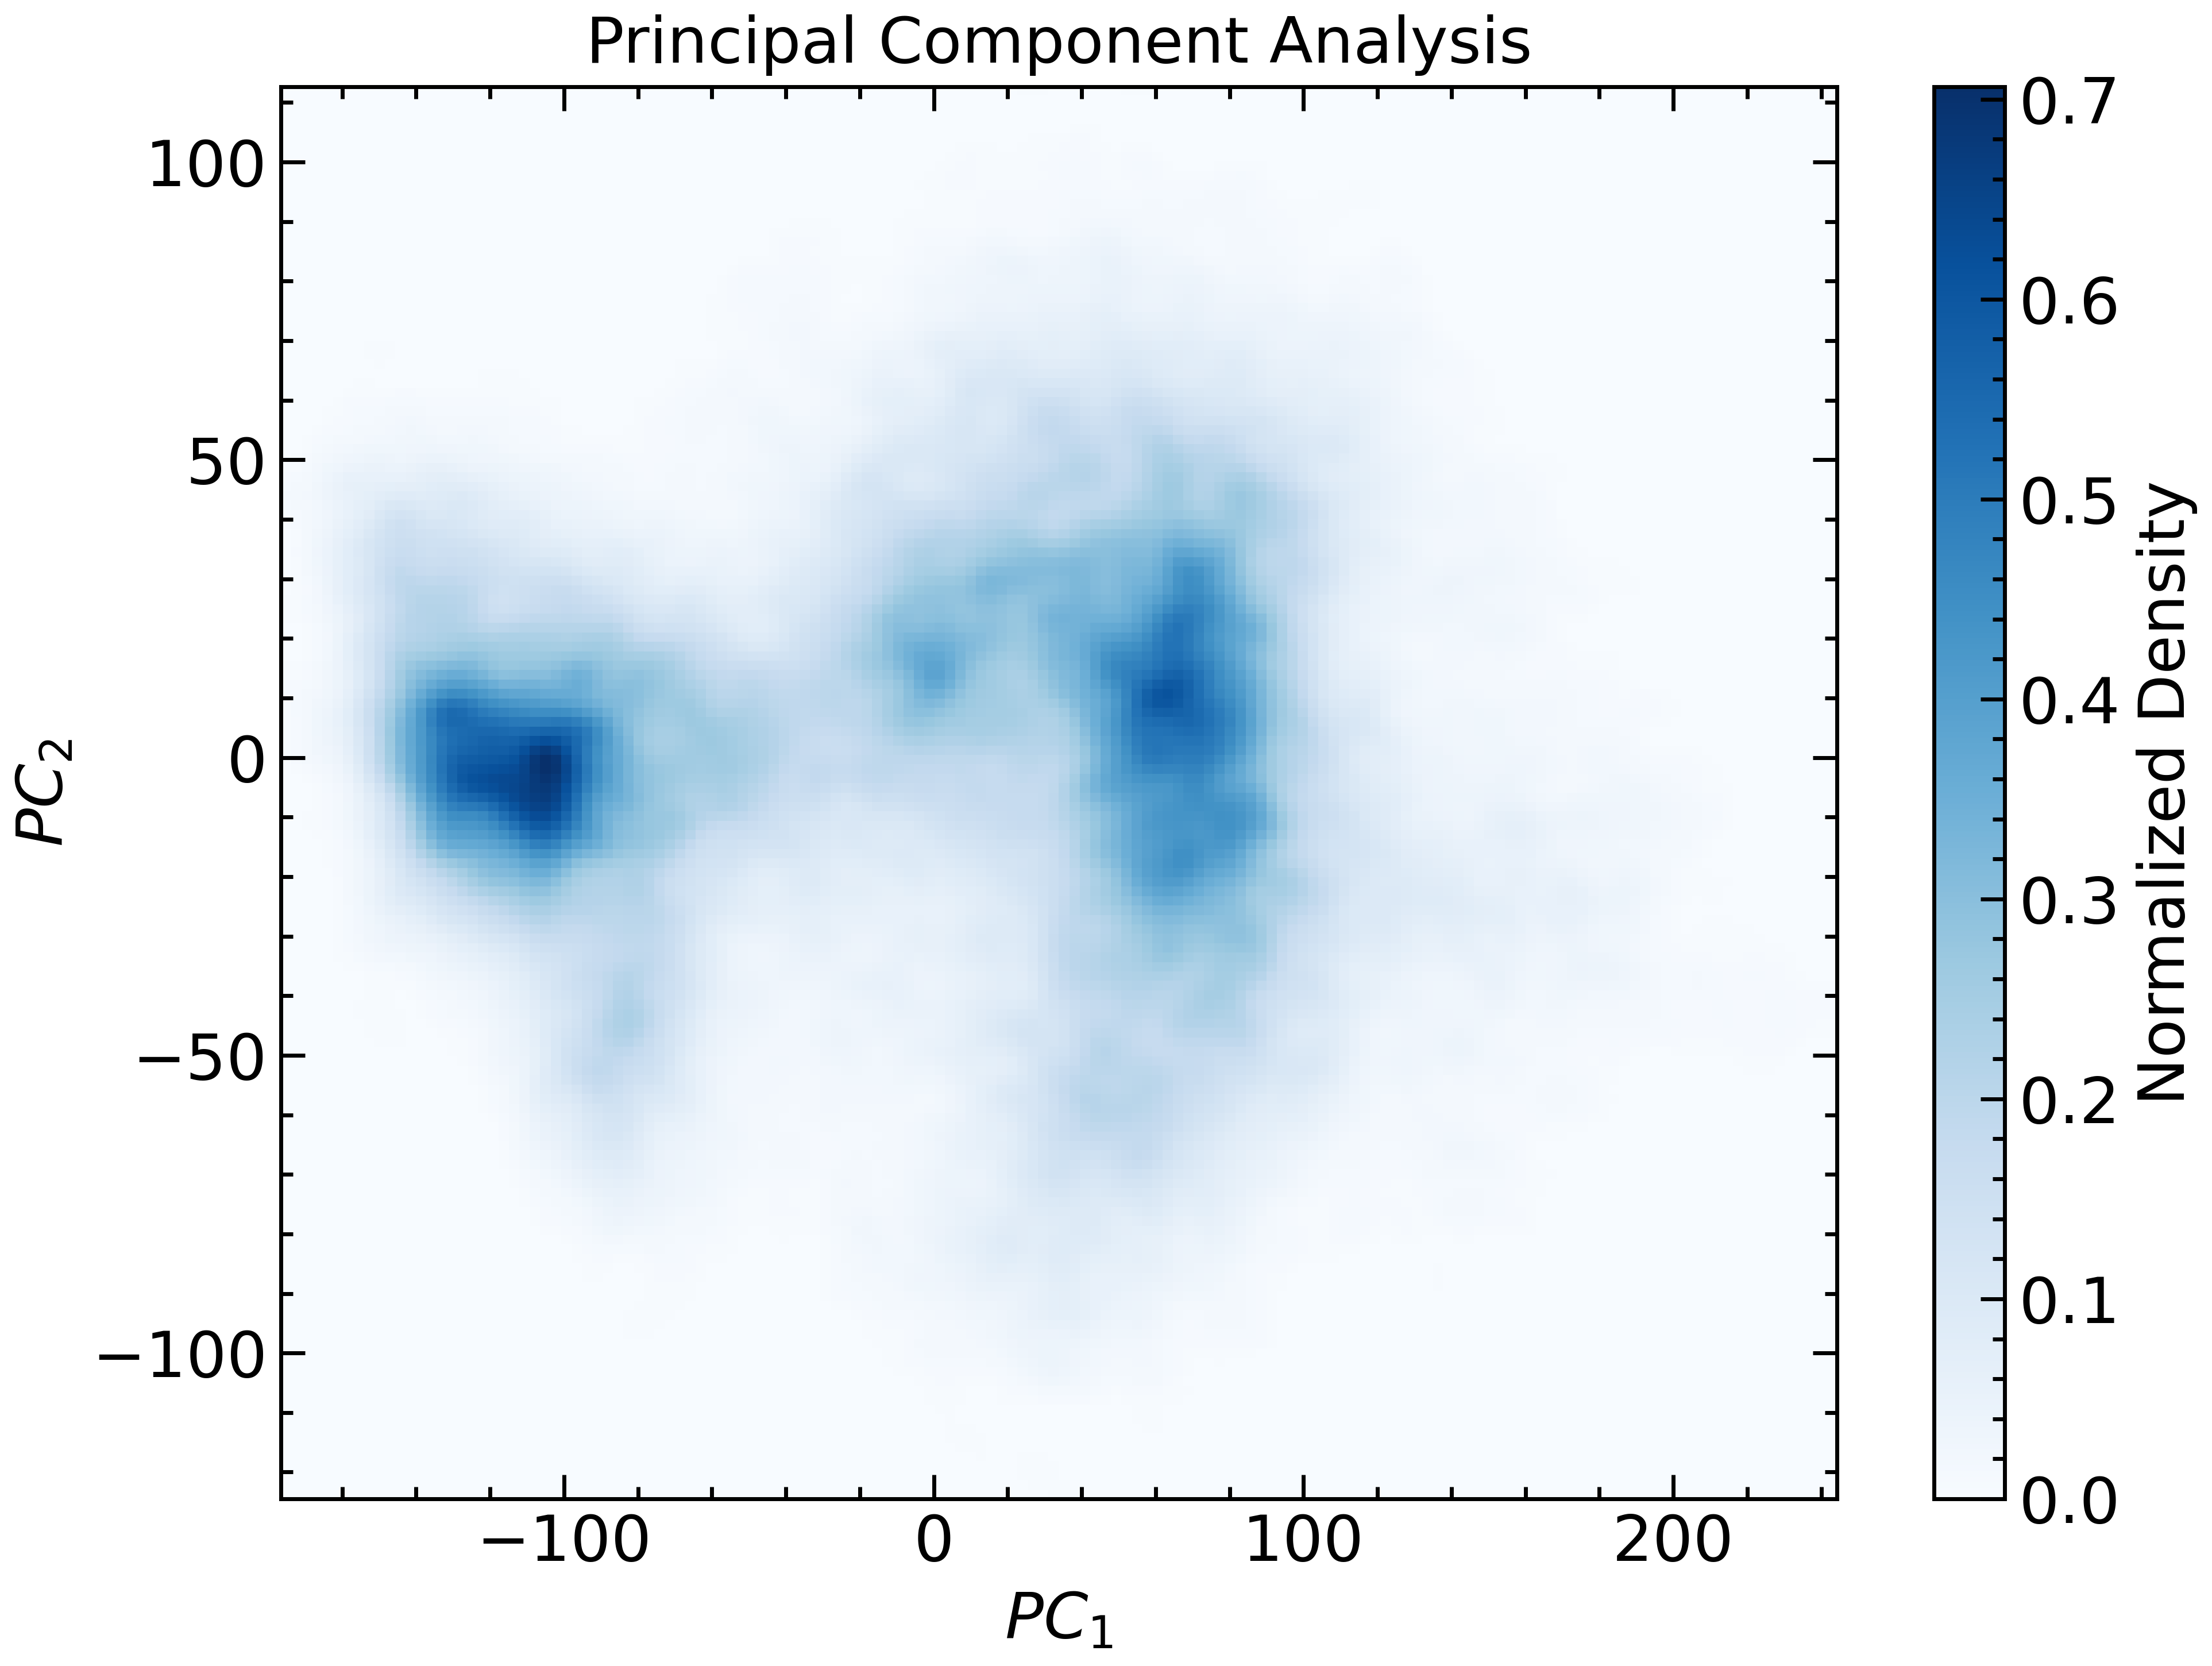

In [ ]:
from scipy.ndimage import gaussian_filter

hist, xedges, yedges = np.histogram2d(df['PC1'], df['PC2'], bins=150)
hist = hist / hist.max()

hist = gaussian_filter(hist, sigma=1.5)

plt.imshow(hist.T, origin='lower', cmap='Blues', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
plt.colorbar(label='Normalized Density')
plt.xlabel(r'$PC_1$')
plt.ylabel('$PC_2$')
plt.title('Principal Component Analysis')
plt.show()

Now, free energy landscape is computed as $\Delta G = -k_BT\ln{\rho}$, with $k_BT = 0.592\; kcal/mol$. For this, I adapted [this method](https://md-davis.readthedocs.io/en/latest/guides/free_energy_landscapes.html).

The contours on the $xy$ plane are those of the density histogram from above.

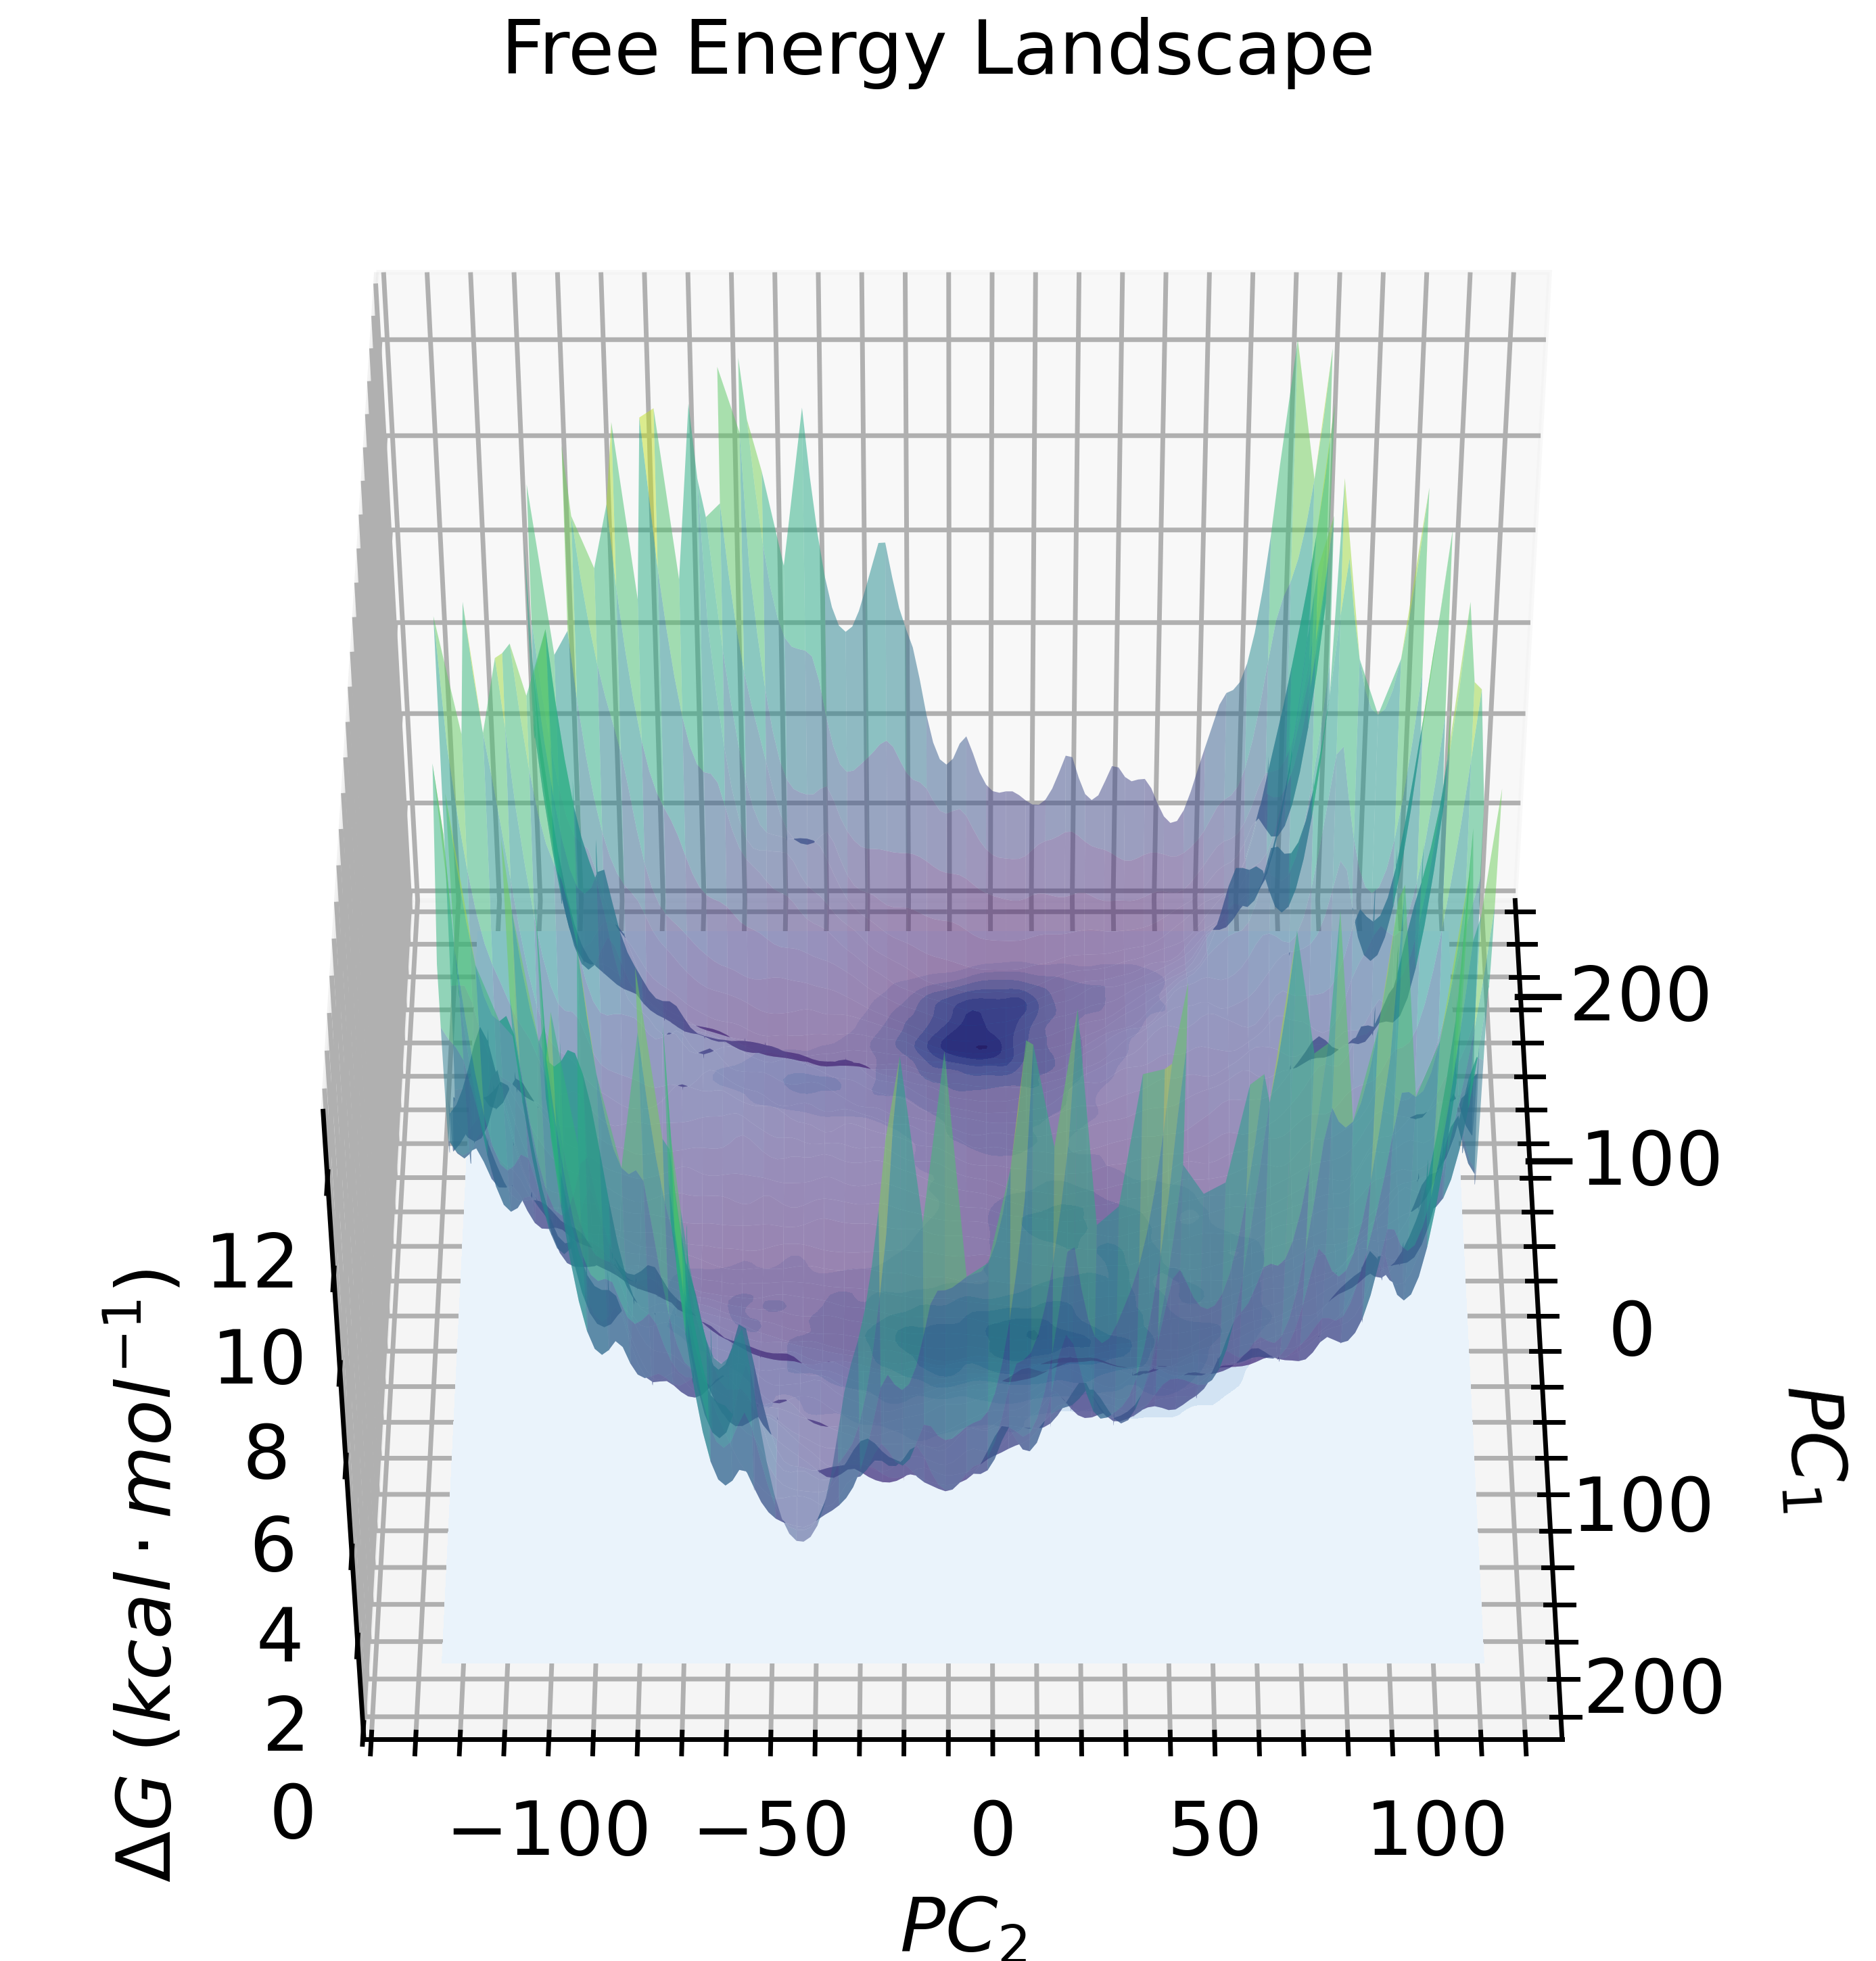

In [93]:
from mpl_toolkits.mplot3d import Axes3D
k_BT_kcalpermol = 0.592
free_energy = -k_BT_kcalpermol * np.log(hist)
X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
Z = free_energy.T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.5)
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel(r'$\Delta G\; \left(kcal \cdot mol^{-1}\right)$', rotation=90, labelpad=10)
ax.set_xlabel(r'$PC_1$', labelpad=30)
ax.xaxis.set_tick_params(pad=10)
ax.set_ylabel(r'$PC_2$', labelpad=5)
ax.yaxis.set_tick_params(pad=0)
plt.title('Free Energy Landscape')

ax.contourf(X, Y, hist.T, zdir='z', offset=np.min(Z), cmap='Blues', alpha=1.0)

ax.view_init(elev=45, azim=0)
plt.show()